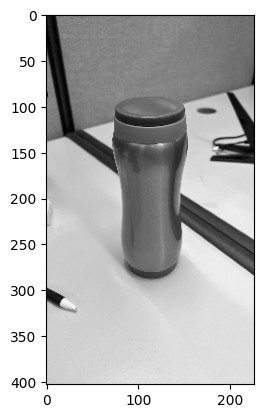

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

filepath = os.getcwd()

image1 = cv2.imread("./sample1.jpg", cv2.IMREAD_GRAYSCALE)
image1 = cv2.resize(image1, dsize=(0,0), fx=0.1, fy=0.1)
plt.imshow(image1, cmap="gray")
plt.show()

In [2]:
image1 = np.float32(image1)

In [3]:
print(image1)

[[ 29.  38.  30. ... 114. 111. 113.]
 [ 18.  36.  25. ... 108. 109. 113.]
 [ 21.  39.  24. ... 110. 108. 109.]
 ...
 [202. 200. 201. ... 221. 221. 220.]
 [200. 205. 205. ... 220. 220. 219.]
 [201. 201. 201. ... 221. 222. 221.]]


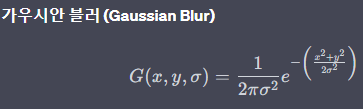

In [4]:
def GaussianKernel(size, sigma):
    arr = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(arr, arr)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma ** 2)) 
    kernel /= kernel.sum()
    return np.array(kernel)

In [5]:
kernel = GaussianKernel(5, 1)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


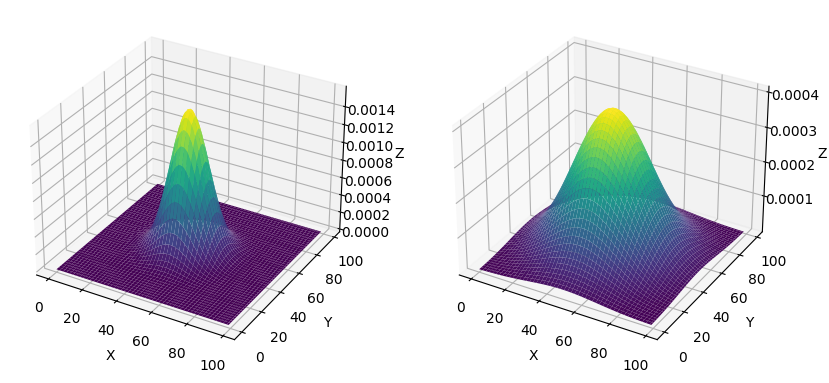

In [6]:
kernel_plot1 = GaussianKernel(100, 10)
kernel_plot2 = GaussianKernel(100, 20)

# x, y, z 좌표 생성
x = np.linspace(0, kernel_plot1.shape[1]-1, kernel_plot1.shape[1])
y = np.linspace(0, kernel_plot1.shape[0]-1, kernel_plot1.shape[0])
x, y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x, y, kernel_plot1, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(x, y, kernel_plot2, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [7]:
def convolve2d(image, kernel):
    image_height, image_width = image.shape[0], image.shape[1]
    kernel_height, kernel_width = kernel.shape[0], kernel.shape[1]

    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    output = np.zeros_like(image)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    
    for x in range(image_height):
        for y in range(image_width):
            region = padded_image[x:x+kernel_height, y:y+kernel_width]
            output[x, y] = np.sum(region * kernel)
    
    return output


def gaussian_filter(image, kernel_size, sigma):
    kernel = GaussianKernel(kernel_size, sigma)
    filter = convolve2d(image, kernel)
    return filter

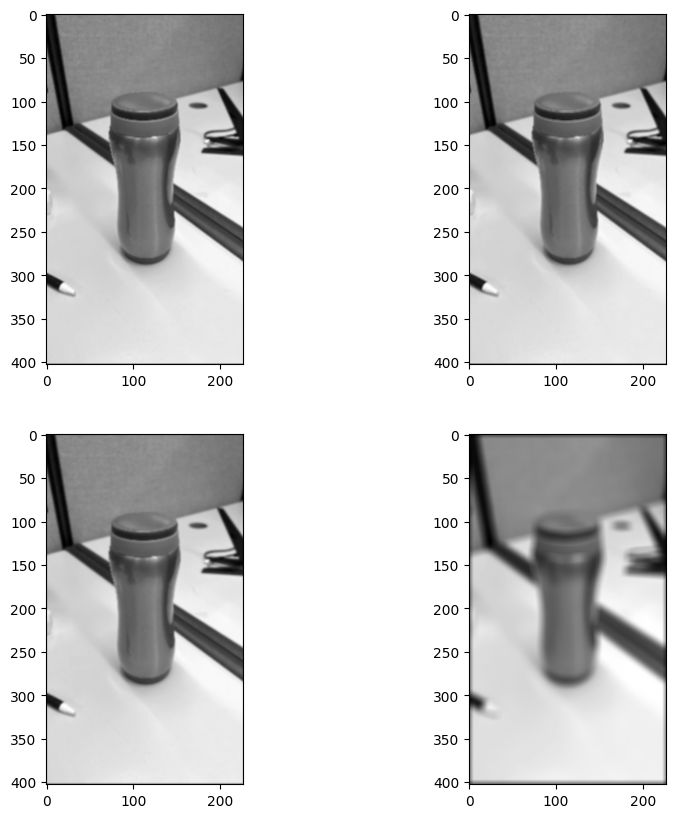

In [8]:
blurred_image1 = gaussian_filter(image1, kernel_size=3, sigma=1)
blurred_image2 = gaussian_filter(image1, kernel_size=3, sigma=10)
blurred_image3 = gaussian_filter(image1, kernel_size=11, sigma=1)
blurred_image4 = gaussian_filter(image1, kernel_size=11, sigma=10)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(blurred_image1, cmap="gray")

plt.subplot(2,2,2)
plt.imshow(blurred_image2, cmap="gray")

plt.subplot(2,2,3)
plt.imshow(blurred_image3, cmap="gray")

plt.subplot(2,2,4)
plt.imshow(blurred_image4, cmap="gray")

plt.show()

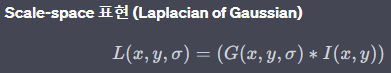  
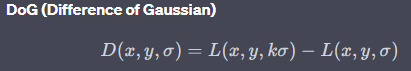

In [9]:
def build_gaussian_pyramid(image, num_octaves, num_scales, sigma):
    
    pyramids = []
    for octave in range(int(num_octaves)):
        scales = []
        for scale in range(int(num_scales)):
            size = 2 ** octave
            k = 2 ** (scale / num_scales)
            sigma_ = sigma * k
            blurred = gaussian_filter(image, kernel_size=3, sigma=sigma_)
            resized = cv2.resize(blurred, (image.shape[1] // size, image.shape[0] // size), interpolation=cv2.INTER_LINEAR)
            scales.append(resized)
        pyramids.append(scales)
    return pyramids


def compute_DoG(pyramids):
    DoGs = []
    for octave in pyramids:
        DoG = []
        for i in range(1, len(octave)):
            DoG.append(octave[i] - octave[i-1])
        DoGs.append(DoG)
    return DoGs

In [10]:
pyramid = build_gaussian_pyramid(image1, 4., 5., 1.)
print(len(pyramid))
print(len(pyramid[0]))
print(len(pyramid[0][0]))
print(len(pyramid[0][0][0]))

4
5
403
227


In [11]:
print(len(pyramid[1][0]))
print(len(pyramid[1][0][0]))
print(len(pyramid[2][0]))
print(len(pyramid[2][0][0]))
print(len(pyramid[3][0]))
print(len(pyramid[3][0][0]))

201
113
100
56
50
28


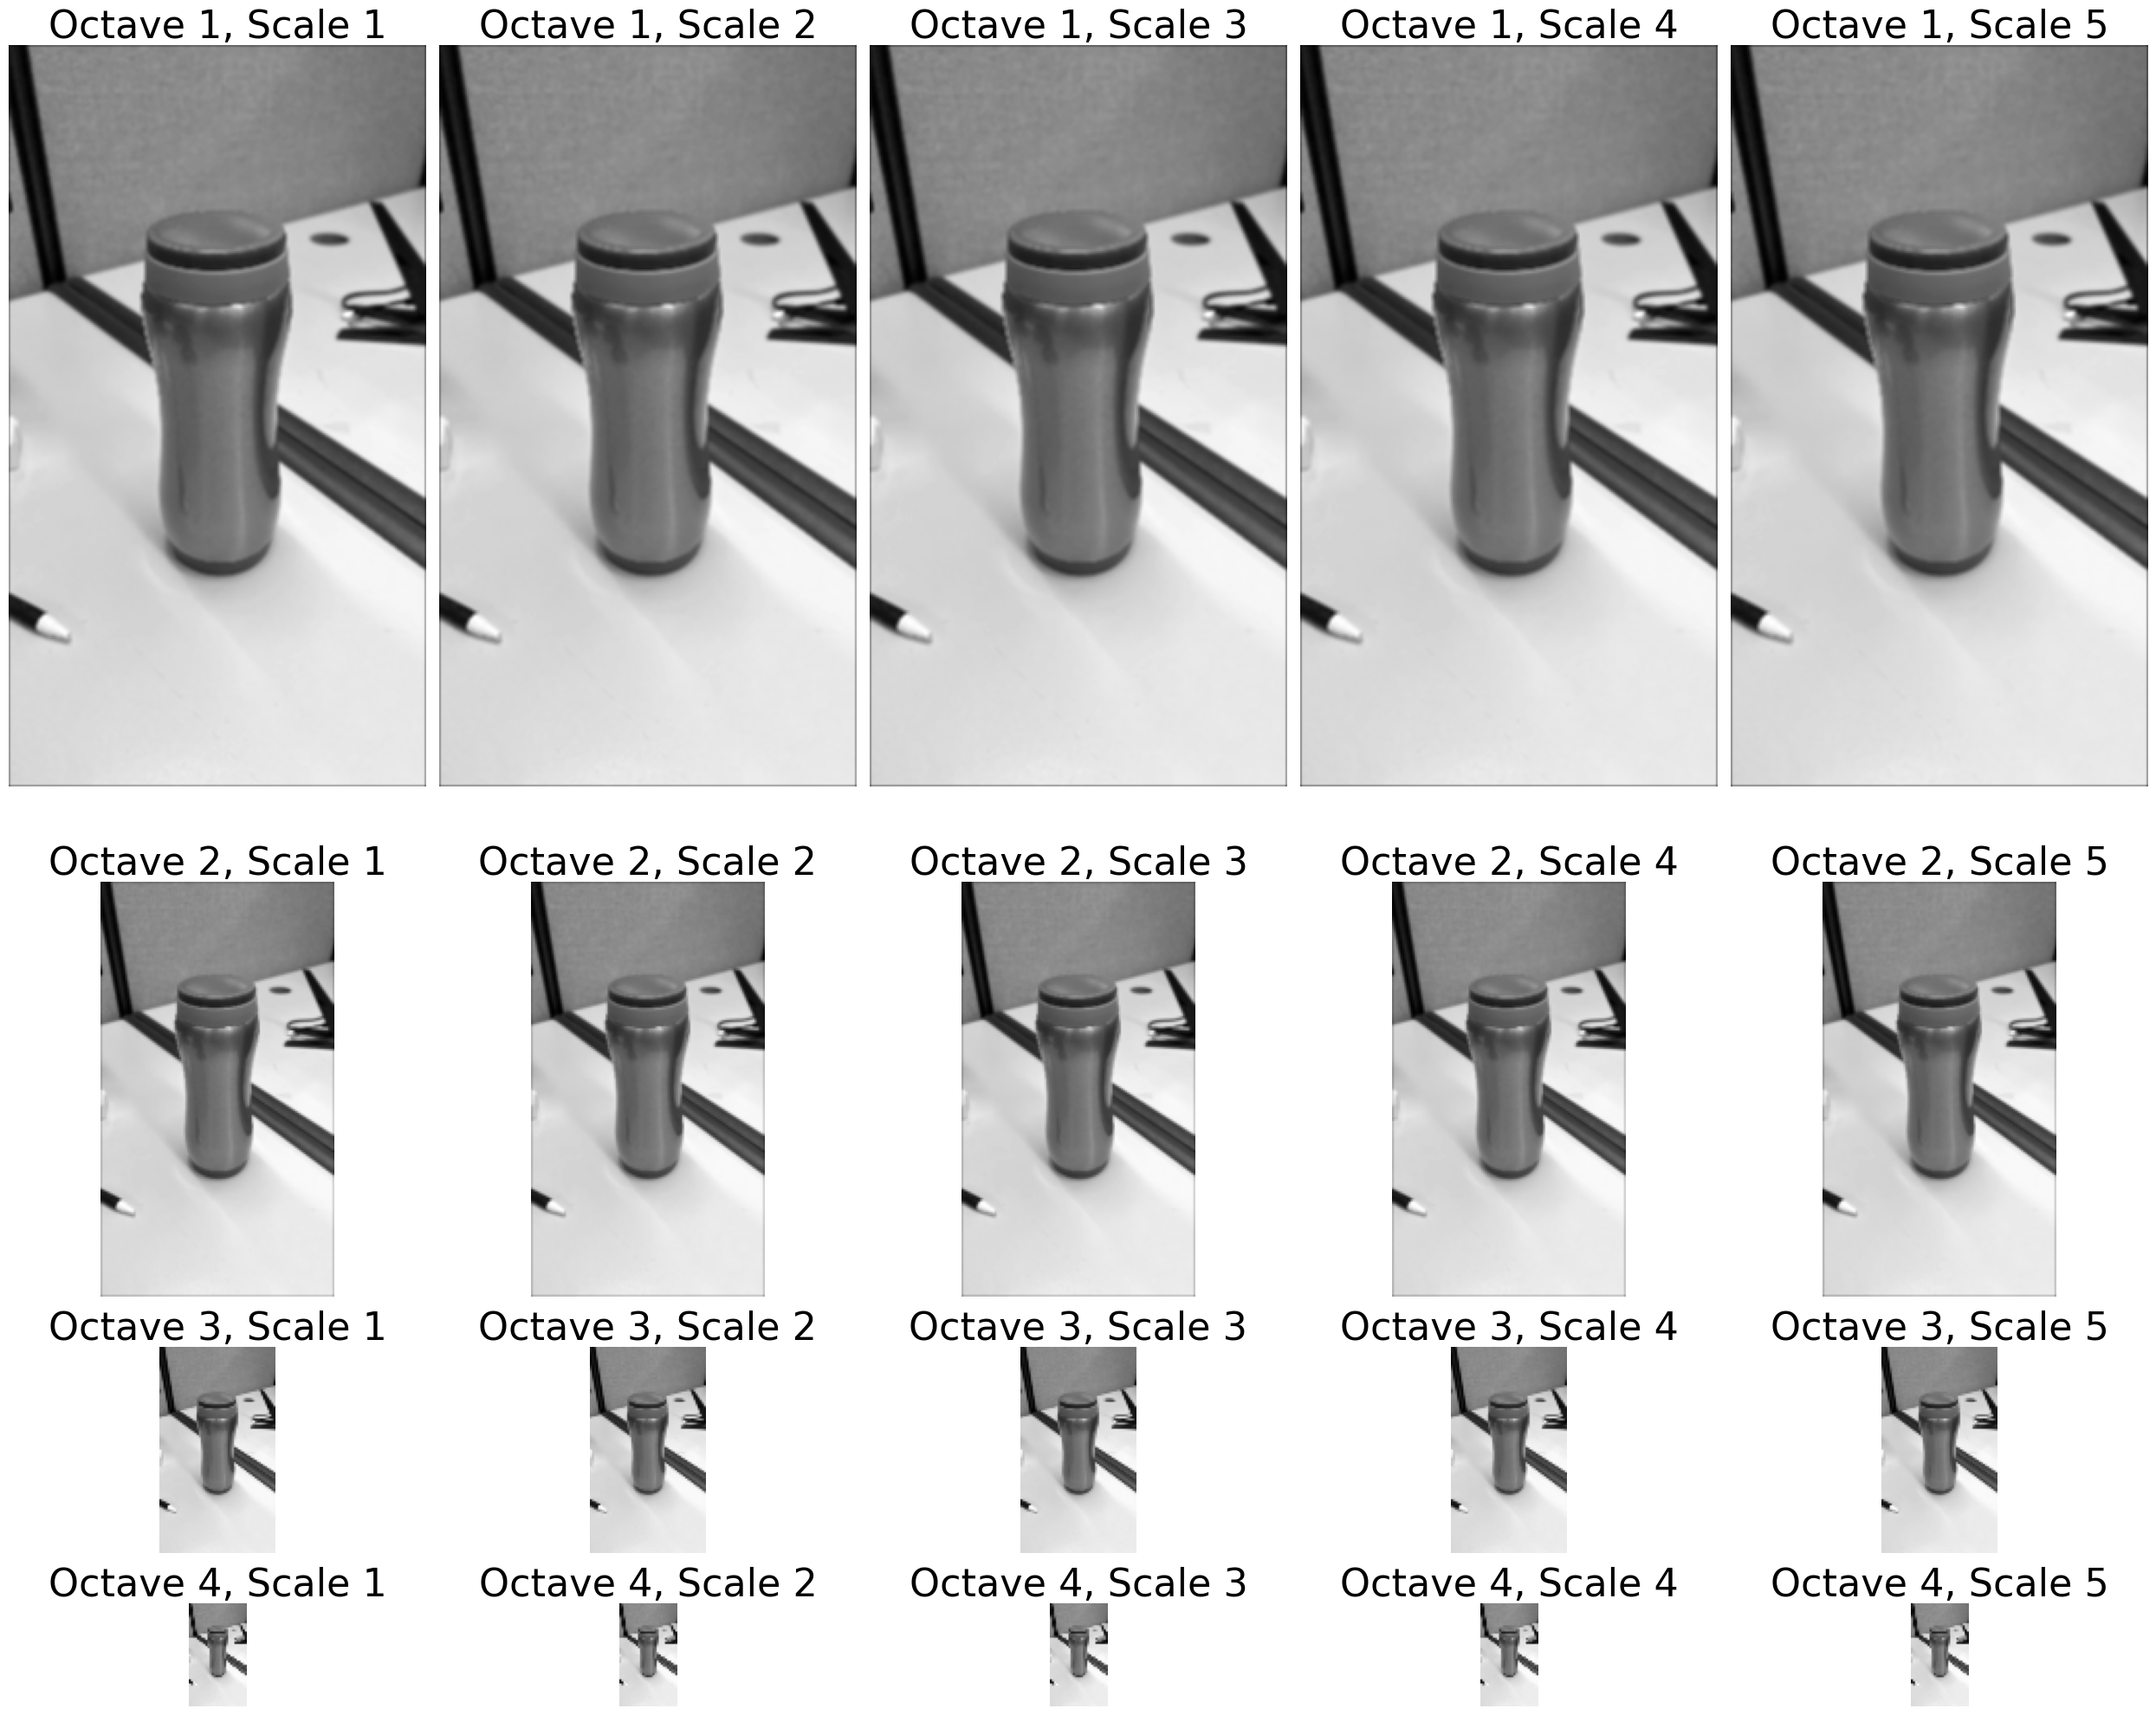

In [12]:
from matplotlib import gridspec

def visualize_pyramid(pyramids):
    num_octaves = len(pyramids)
    num_scales = len(pyramids[0])
    
    # 각 옥타브의 첫 번째 이미지의 높이를 기반으로 행의 높이 비율을 설정합니다.
    heights = [len(pyramids[i][0]) for i in range(num_octaves)]
    total_height = sum(heights)
    height_ratios = [h / total_height for h in heights]
    
    # gridspec을 사용하여 다른 높이 비율을 갖는 서브플롯을 생성합니다.
    gs = gridspec.GridSpec(num_octaves, num_scales, height_ratios=height_ratios)
    fig = plt.figure(figsize=(num_scales * 5, num_octaves * 5))
    
    for i in range(num_octaves):
        for j in range(num_scales):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(pyramids[i][j], cmap='gray')
            ax.axis('off')
            ax.set_title(f'Octave {i+1}, Scale {j+1}', fontsize=32)
    
    plt.tight_layout()
    plt.show()


visualize_pyramid(pyramid)

In [13]:
DoG = compute_DoG(pyramid)

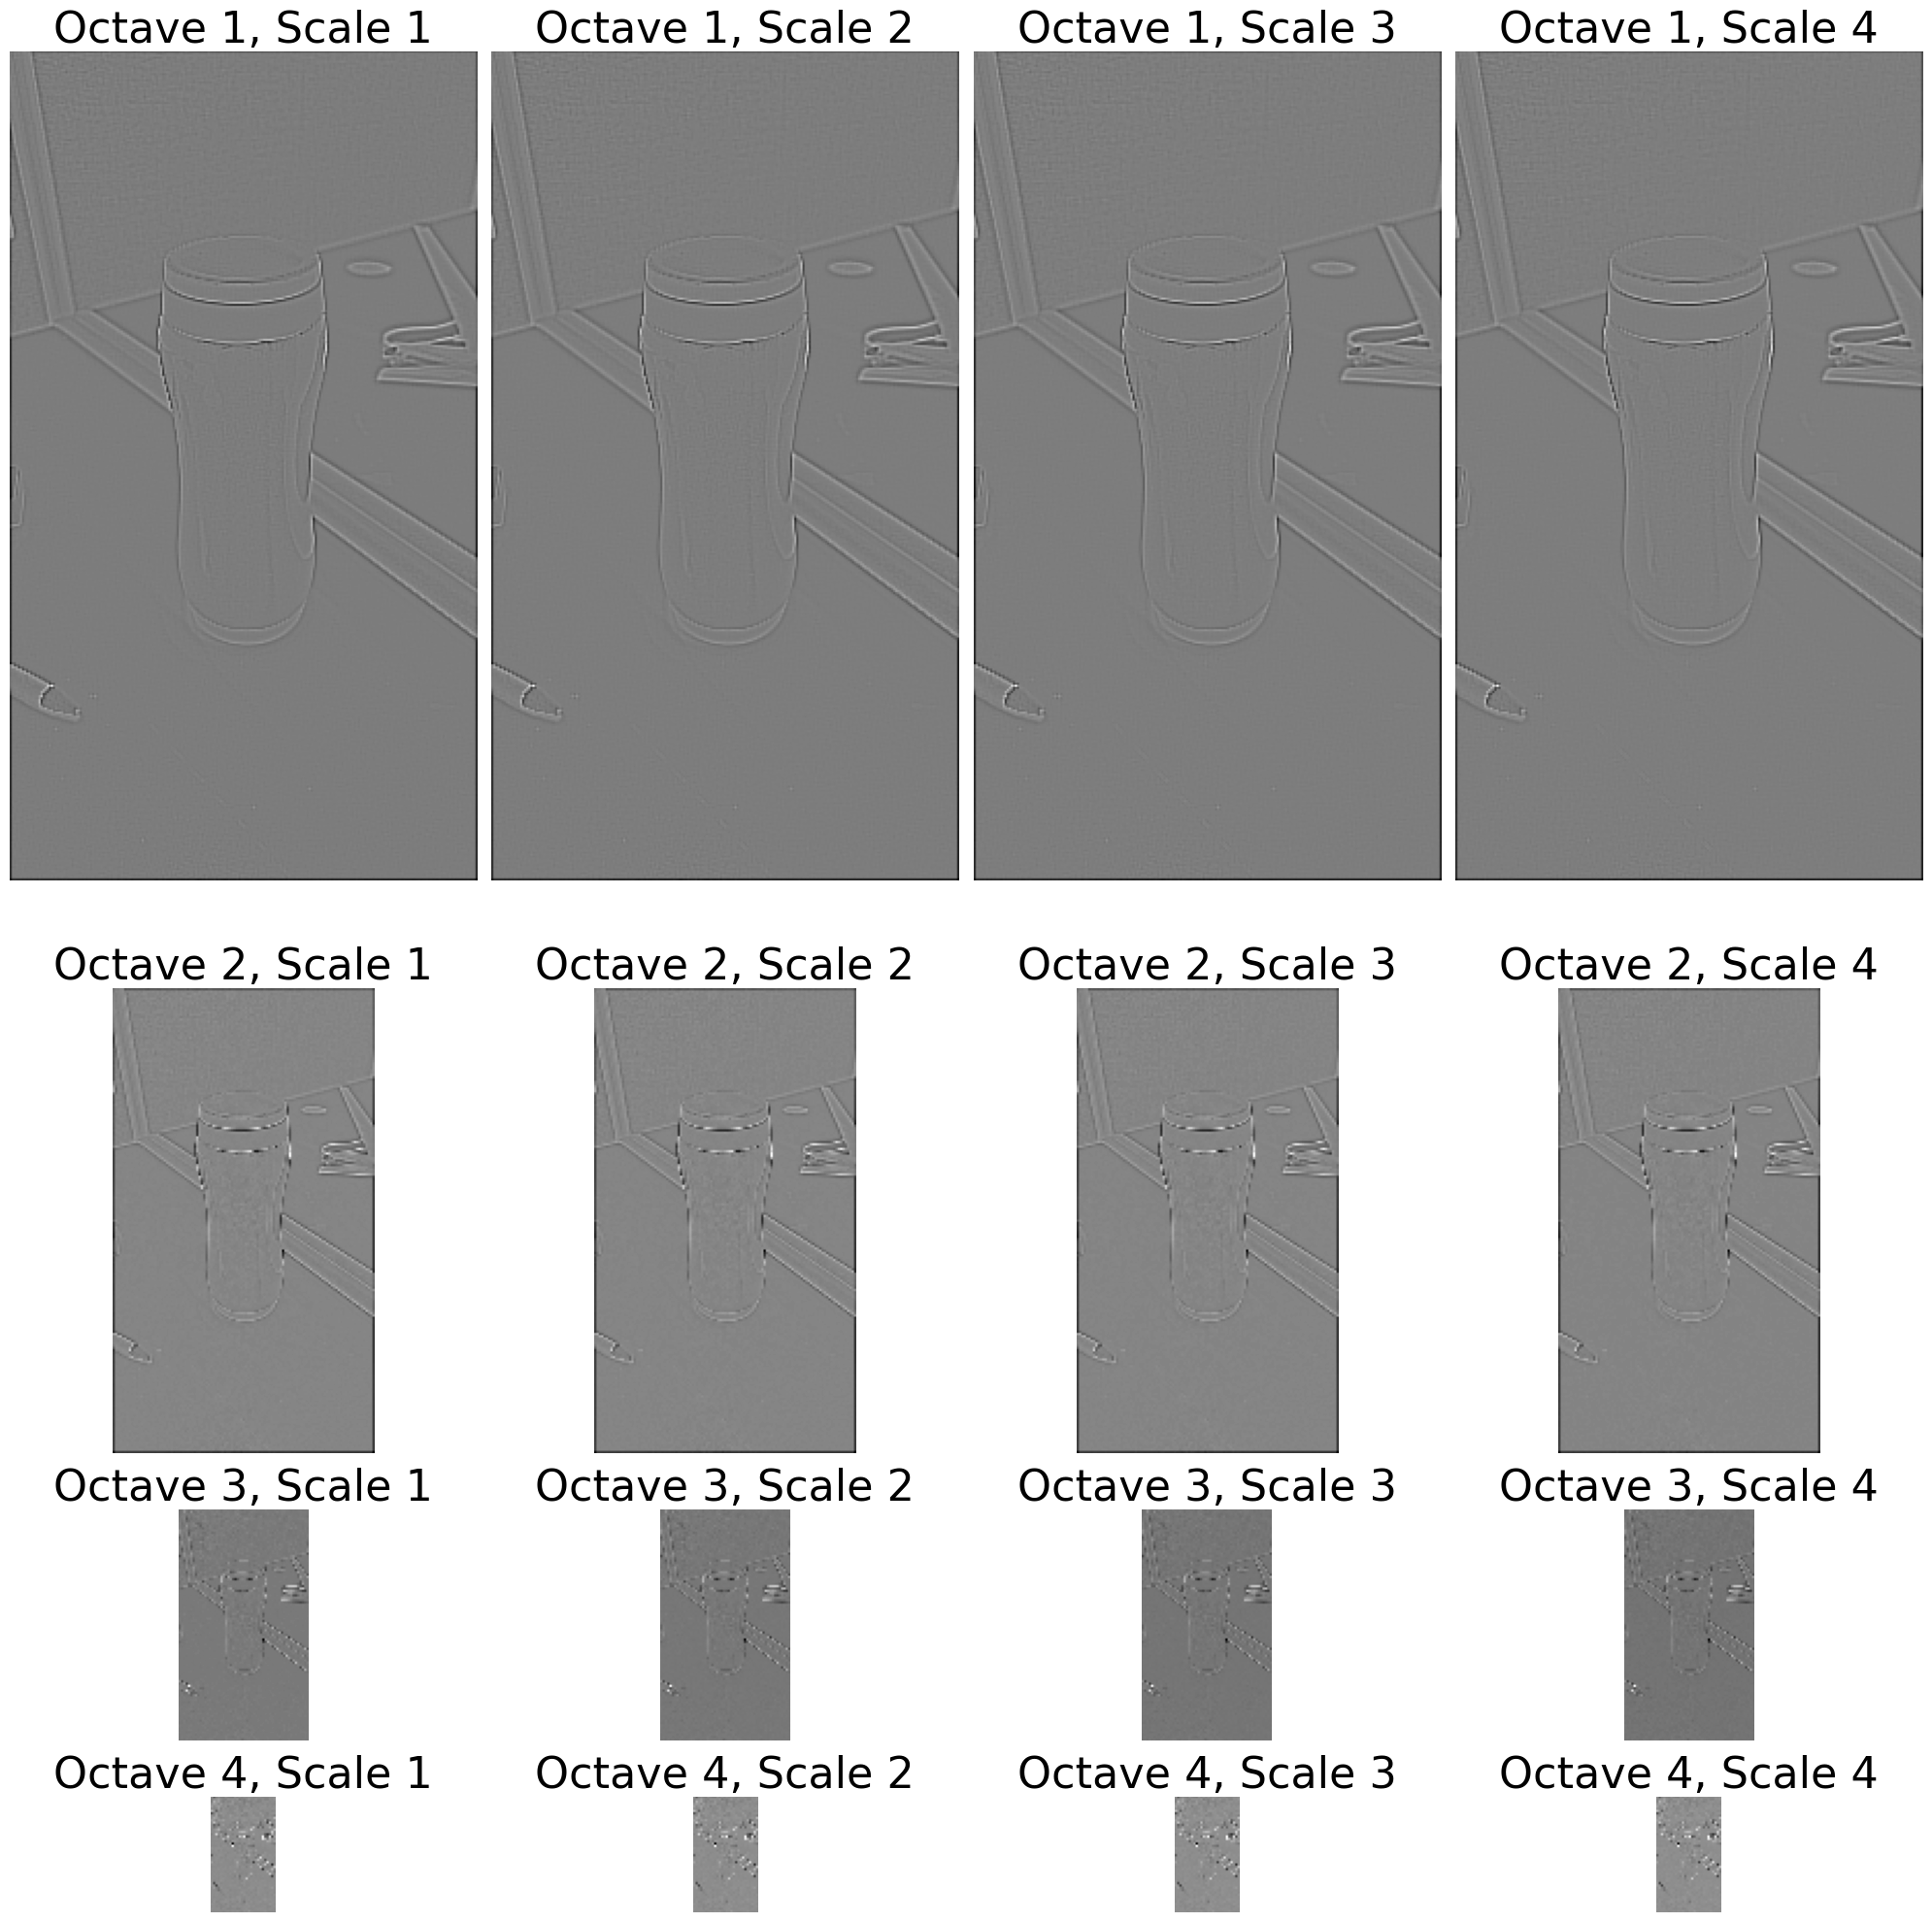

In [14]:
visualize_pyramid(DoG)

In [15]:
print(DoG)

[[array([[-5.58010101e-01, -8.06737900e-01, -4.47534561e-01, ...,
        -1.74747467e+00, -1.66664886e+00, -2.44736099e+00],
       [ 1.56383514e-02, -2.90266037e-01,  2.18700409e-01, ...,
         9.48333740e-02,  7.63244629e-02, -1.72608185e+00],
       [-9.02061462e-02, -5.28484344e-01,  1.19859695e-01, ...,
        -4.84161377e-02,  4.84161377e-02, -1.65826416e+00],
       ...,
       [-2.99624634e+00,  5.39245605e-02,  1.66473389e-02, ...,
        -4.62341309e-03, -2.97698975e-02, -3.26712036e+00],
       [-2.98435974e+00, -9.94567871e-02, -7.15637207e-02, ...,
         3.62854004e-02,  2.13928223e-02, -3.22619629e+00],
       [-4.26490021e+00, -2.97497559e+00, -2.96195984e+00, ...,
        -3.30065918e+00, -3.33967590e+00, -4.73471069e+00]], dtype=float32), array([[-4.0460873e-01, -6.0020638e-01, -3.3174324e-01, ...,
        -1.3003464e+00, -1.2449799e+00, -1.7925835e+00],
       [ 5.0258636e-03, -2.1416473e-01,  1.6396713e-01, ...,
         6.7840576e-02,  5.7495117e-02, -1.284

In [16]:
def find_keypoints(DoGs, threshold=0.5):
    keypoints = []
    for o, octave in enumerate(DoGs):
        for s, scale in enumerate(octave):
            height, width = scale.shape
            for i in range(1, height - 1):
                for j in range(1, width - 1):
                    patch = scale[i-1:i+2, j-1:j+2]
                    pixel = scale[i, j]
                    
                    # 그래디언트의 크기에 대한 임계값을 적용
                    if np.abs(pixel) < threshold:
                        continue
                    
                    if pixel == np.max(patch) or pixel == np.min(patch):
                        keypoints.append((i, j, o, s))
    return keypoints


In [17]:
keypoints = find_keypoints(DoG)
keypoints

[(1, 9, 0, 0),
 (2, 1, 0, 0),
 (3, 10, 0, 0),
 (4, 11, 0, 0),
 (5, 10, 0, 0),
 (6, 22, 0, 0),
 (8, 12, 0, 0),
 (8, 41, 0, 0),
 (10, 11, 0, 0),
 (10, 27, 0, 0),
 (10, 36, 0, 0),
 (11, 12, 0, 0),
 (12, 11, 0, 0),
 (15, 13, 0, 0),
 (16, 12, 0, 0),
 (18, 12, 0, 0),
 (18, 14, 0, 0),
 (21, 14, 0, 0),
 (23, 13, 0, 0),
 (24, 15, 0, 0),
 (26, 15, 0, 0),
 (28, 15, 0, 0),
 (29, 14, 0, 0),
 (30, 16, 0, 0),
 (33, 16, 0, 0),
 (35, 17, 0, 0),
 (36, 15, 0, 0),
 (37, 1, 0, 0),
 (37, 17, 0, 0),
 (39, 16, 0, 0),
 (41, 16, 0, 0),
 (42, 18, 0, 0),
 (44, 2, 0, 0),
 (44, 18, 0, 0),
 (47, 17, 0, 0),
 (48, 3, 0, 0),
 (49, 2, 0, 0),
 (50, 3, 0, 0),
 (50, 19, 0, 0),
 (51, 2, 0, 0),
 (52, 19, 0, 0),
 (53, 18, 0, 0),
 (54, 4, 0, 0),
 (55, 3, 0, 0),
 (55, 18, 0, 0),
 (55, 20, 0, 0),
 (58, 3, 0, 0),
 (58, 20, 0, 0),
 (59, 5, 0, 0),
 (60, 4, 0, 0),
 (60, 19, 0, 0),
 (61, 21, 0, 0),
 (62, 4, 0, 0),
 (63, 6, 0, 0),
 (64, 22, 0, 0),
 (65, 20, 0, 0),
 (66, 22, 0, 0),
 (67, 5, 0, 0),
 (67, 20, 0, 0),
 (69, 7, 0, 0),
 (70,

In [18]:
def visualize_keypoints(pyramids, keypoints):
    num_octaves = len(pyramids)
    num_scales = len(pyramids[0])

    # 각 옥타브의 첫 번째 이미지의 높이를 기반으로 행의 높이 비율을 설정합니다.
    heights = [len(pyramids[i][0]) for i in range(num_octaves)]
    total_height = sum(heights)
    height_ratios = [h / total_height for h in heights]

    # gridspec을 사용하여 다른 높이 비율을 갖는 서브플롯을 생성합니다.
    gs = gridspec.GridSpec(num_octaves, num_scales, height_ratios=height_ratios)
    fig = plt.figure(figsize=(num_scales * 5, num_octaves * 5))

    for i in range(num_octaves):
        for j in range(num_scales):
            ax = fig.add_subplot(gs[i, j])
            ax.imshow(pyramids[i][j], cmap='gray')
            ax.axis('off')
            ax.set_title(f'Octave {i+1}, Scale {j+1}', fontsize=32)

            # 해당 옥타브와 스케일의 키 포인트를 찾아 표시합니다.
            for keypoint in keypoints:
                if keypoint[2] == i and keypoint[3] == j:
                    ax.plot(keypoint[1], keypoint[0], 'r.', markersize=5)

    plt.tight_layout()
    plt.show()

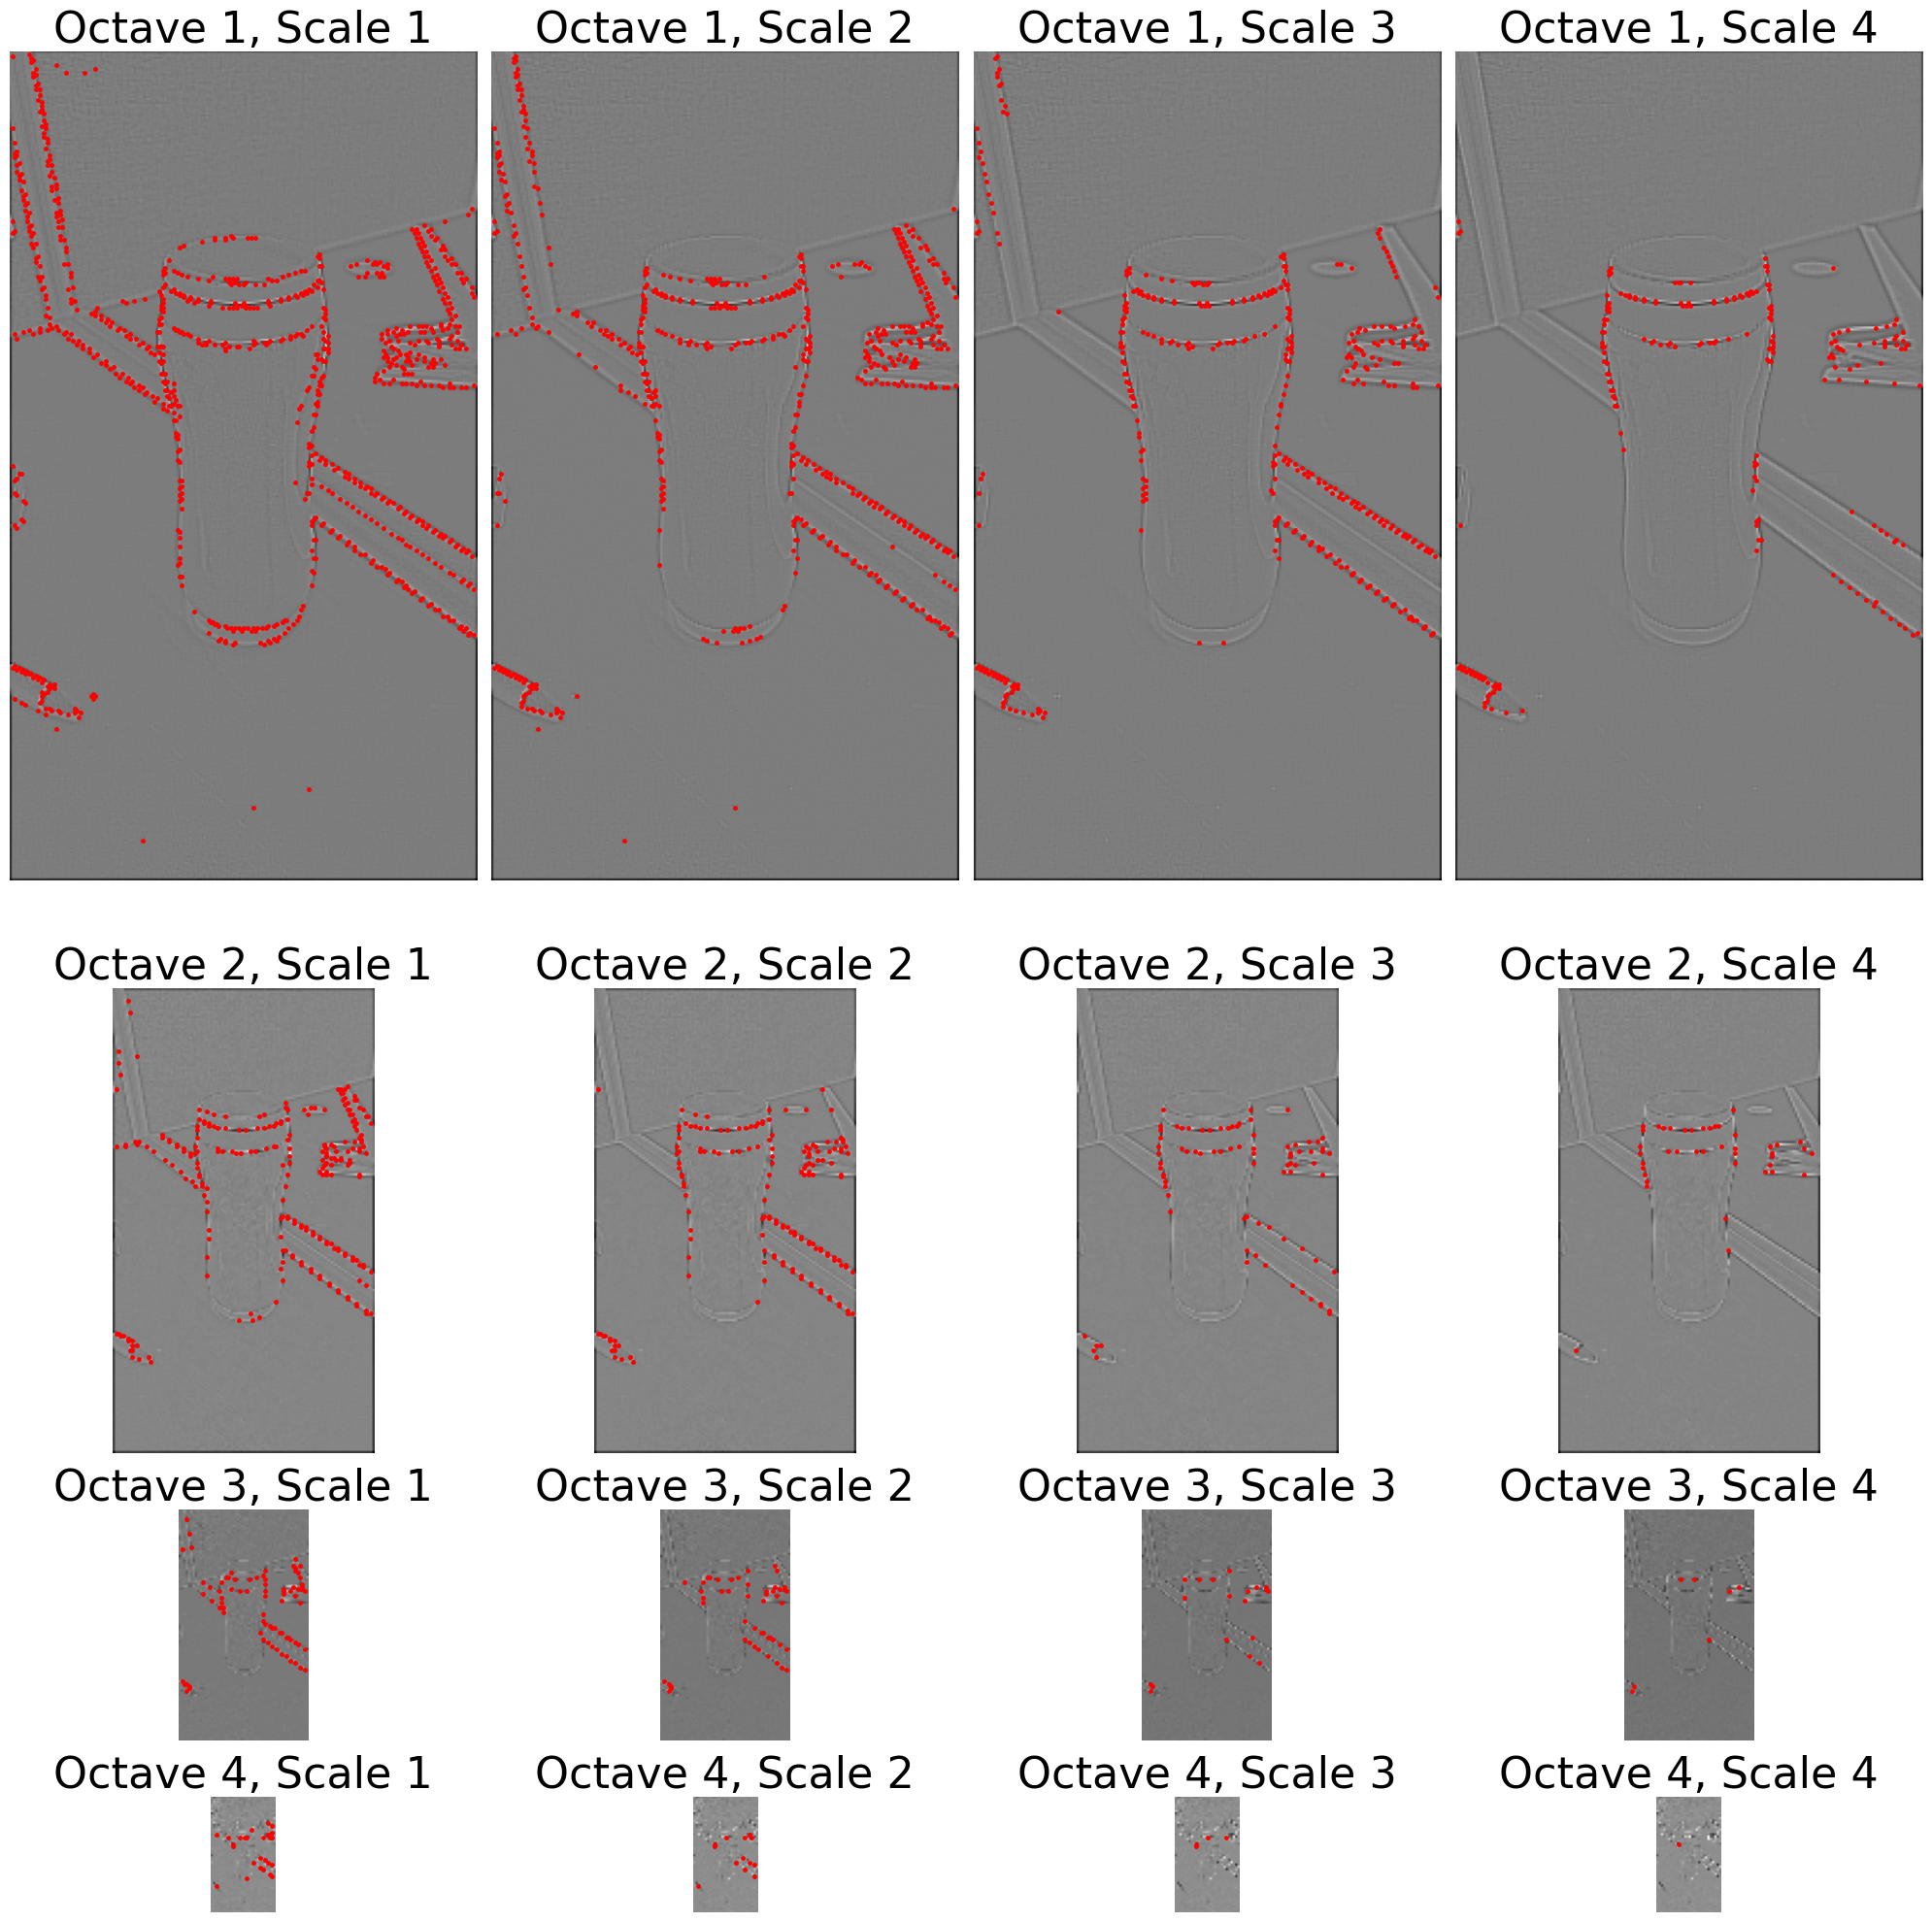

In [19]:
# 키 포인트와 함께 피라미드 시각화
visualize_keypoints(DoG, keypoints)


sobel filter  
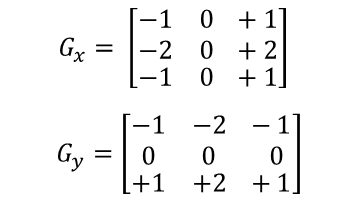

In [20]:
def show_sobel_filter(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    plt.subplot(1,2,1)
    plt.imshow(gradient_x, cmap = "gray")
    plt.subplot(1,2,2)
    plt.imshow(gradient_y, cmap = "gray")
    plt.show()

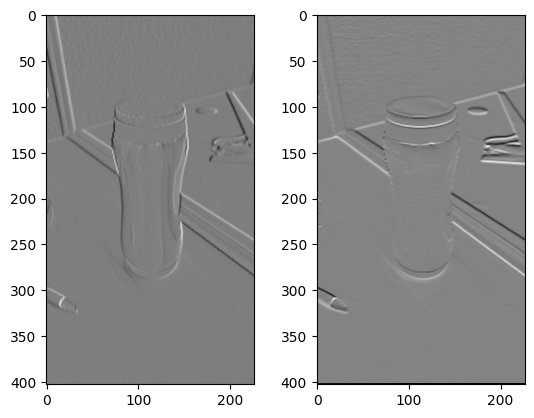

In [21]:
show_sobel_filter(image1)

In [22]:
def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    gradient_x = convolve2d(image, kernel_x)
    gradient_y = convolve2d(image, kernel_y)
    
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    orientation = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    orientation[orientation < 0] += 360
    
    return magnitude, orientation

def assign_orientations(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
        
    for i, keypoint in enumerate(keypoints):
        y, x, o, s = keypoint
        magnitude, orientation = gradients[o][s]
        
        hist, bins = np.histogram(orientation[max(y-8,0):min(y+8,magnitude.shape[0]), 
                                              max(x-8,0):min(x+8,magnitude.shape[1])], 
                                   bins=36, range=(0, 360))
        max_bin = np.argmax(hist)
        
        keypoints[i] = {'position': (y, x), 'octave': o, 'scale': s, 'orientation': bins[max_bin], 'magnitude': hist[max_bin]}
    
    return keypoints
        
def compute_descriptors(keypoints, pyramids):
    gradients = {}
    for o in range(len(pyramids)):
        gradients[o] = [compute_gradients(scale) for scale in pyramids[o]]
    
    descriptors = []
    for keypoint in keypoints:
        y, x = keypoint['position']
        o, s = keypoint['octave'], keypoint['scale']
        magnitude, orientation = gradients[o][s]
        
        # Compute the descriptor
        descriptor = []
        for dx in range(max(y-8,0), min(y+8,magnitude.shape[0]), 4):
            for dy in range(max(x-8,0), min(x+8,magnitude.shape[1]), 4):
                hist, bins = np.histogram(orientation[dx:dx+4, dy:dy+4], bins=8, range=(0, 360))
                descriptor.extend(hist)
        
        # Normalize the descriptor
        descriptor = np.array(descriptor)
        descriptor = descriptor / np.sqrt(np.sum(descriptor**2))
        descriptors.append(descriptor)
    
    return descriptors


In [23]:
import time

def sift_algorithm(image, num_octaves=4, num_scales=5, sigma=1):
    start_time = time.time()
    
    # Step 1: Scale-space Extrema Detection
    pyramids_start_time = time.time()
    pyramids = build_gaussian_pyramid(image, num_octaves, num_scales, sigma)
    print(f"Scale-space Extrema Detection time: {time.time() - pyramids_start_time:.4f} seconds")
    
    # Step 2: Keypoint Localization
    keypoints_start_time = time.time()
    DoGs = compute_DoG(pyramids)
    keypoints = find_keypoints(DoGs)
    print(f"Keypoint Localization time: {time.time() - keypoints_start_time:.4f} seconds")
    
    # Step 3: Orientation Assignment
    orientations_start_time = time.time()
    keypoints_with_orientations = assign_orientations(keypoints, pyramids)
    print(f"Orientation Assignment time: {time.time() - orientations_start_time:.4f} seconds")
    
    # Step 4: Keypoint Descriptor
    descriptors_start_time = time.time()
    descriptors = compute_descriptors(keypoints_with_orientations, pyramids)
    print(f"Keypoint Descriptor time: {time.time() - descriptors_start_time:.4f} seconds")
    
    print(f"Total time: {time.time() - start_time:.4f} seconds")
    
    return keypoints_with_orientations, descriptors



In [43]:
def visualize_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    for keypoint in keypoints:
        y, x = keypoint['position']
        plt.plot(x, y, 'r.', markersize=5)
        orientation = keypoint.get('orientation', 0)
        magnitude = keypoint.get('magnitude', 5)
        dx = magnitude * np.cos(np.deg2rad(orientation)) * 0.2
        dy = magnitude * np.sin(np.deg2rad(orientation)) * 0.2
        plt.arrow(x, y, dx, dy, color='y', width=0.1)
    plt.show()

def visualize_descriptors(image, keypoints):
    plt.imshow(image, cmap='gray')
    for keypoint in keypoints:
        y, x = keypoint['position']
        plt.plot(x, y, 'bo')  # 키포인트 위치에 파란색 점 그리기
        
        # 16x16 영역 그리기
        plt.plot([x-8, x+8], [y-8, y-8], 'r-')
        plt.plot([x+8, x+8], [y-8, y+8], 'r-')
        plt.plot([x+8, x-8], [y+8, y+8], 'r-')
        plt.plot([x-8, x-8], [y+8, y-8], 'r-')
        
        # 4x4 그리드 그리기
        for i in range(3):
            plt.plot([x-8, x+8], [y-4-(i*4), y-4-(i*4)], 'r--')
            plt.plot([x-4-(i*4), x-4-(i*4)], [y-8, y+8], 'r--')
    plt.show()
    

In [25]:
keypoints, descriptors = sift_algorithm(image1)

Scale-space Extrema Detection time: 4.3878 seconds
Keypoint Localization time: 0.5939 seconds
Orientation Assignment time: 3.1077 seconds
Keypoint Descriptor time: 4.1813 seconds
Total time: 12.2711 seconds


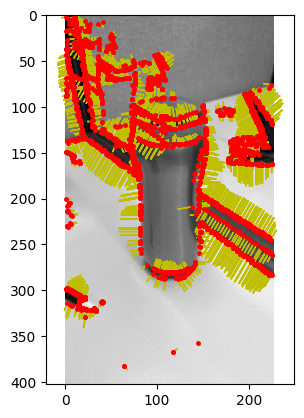

In [26]:
visualize_keypoints(image1, keypoints)

In [28]:
print(len(keypoints))
print(len(descriptors))

2874
2874


Keypoint 0:
  X: 4.516631126403809, Y: 210.05703735351562
  Size: 3.2540969848632812
  Angle: 190.7162628173828
Keypoint 1:
  X: 9.752288818359375, Y: 309.47088623046875
  Size: 10.24633502960205
  Angle: 98.50961303710938
Keypoint 2:
  X: 9.752288818359375, Y: 309.47088623046875
  Size: 10.24633502960205
  Angle: 300.38739013671875
Keypoint 3:
  X: 15.005562782287598, Y: 21.416955947875977
  Size: 2.1677863597869873
  Angle: 349.81939697265625
Keypoint 4:
  X: 16.788854598999023, Y: 128.92654418945312
  Size: 2.29335618019104
  Angle: 171.38238525390625
Keypoint 5:
  X: 17.05120277404785, Y: 30.366945266723633
  Size: 3.301002264022827
  Angle: 350.0401916503906
Keypoint 6:
  X: 17.558889389038086, Y: 308.4169006347656
  Size: 2.400378942489624
  Angle: 39.261749267578125
Keypoint 7:
  X: 17.89255142211914, Y: 23.061769485473633
  Size: 6.4798264503479
  Angle: 350.05267333984375
Keypoint 8:
  X: 18.039793014526367, Y: 38.31483459472656
  Size: 2.7626559734344482
  Angle: 349.46643066

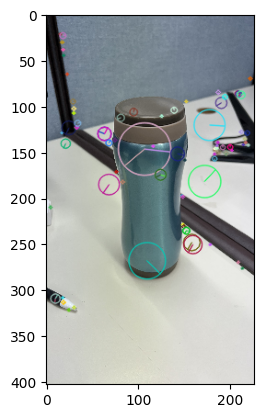

In [16]:
import cv2
img = cv2.imread('./sample1.jpg')
img = cv2.resize(img, dsize=(0,0), fx=0.1, fy=0.1)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# SIFT 추출기 생성
sift = cv2.SIFT_create()
# 키 포인트 검출과 서술자 계산
keypoints, descriptor = sift.detectAndCompute(gray, None)
for i, keypoint in enumerate(keypoints):
    print(f"Keypoint {i}:")
    print(f"  X: {keypoint.pt[0]}, Y: {keypoint.pt[1]}")
    print(f"  Size: {keypoint.size}")
    print(f"  Angle: {keypoint.angle}")
print(descriptor)

# 키 포인트 그리기
img_draw = cv2.drawKeypoints(img, keypoints, None, \
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# 결과 출력
plt.imshow(img_draw)
plt.show()


In [15]:
for i, keypoint in enumerate(keypoints):
    print(f"Keypoint {i}:")
    print(f"  X: {keypoint.pt[0]}, Y: {keypoint.pt[1]}")
    print(f"  Size: {keypoint.size}")
    print(f"  Angle: {keypoint.angle}")

Keypoint 0:
  X: 4.516631126403809, Y: 210.05703735351562
  Size: 3.2540969848632812
  Angle: 190.7162628173828
Keypoint 1:
  X: 9.752288818359375, Y: 309.47088623046875
  Size: 10.24633502960205
  Angle: 98.50961303710938
Keypoint 2:
  X: 9.752288818359375, Y: 309.47088623046875
  Size: 10.24633502960205
  Angle: 300.38739013671875
Keypoint 3:
  X: 15.005562782287598, Y: 21.416955947875977
  Size: 2.1677863597869873
  Angle: 349.81939697265625
Keypoint 4:
  X: 16.788854598999023, Y: 128.92654418945312
  Size: 2.29335618019104
  Angle: 171.38238525390625
Keypoint 5:
  X: 17.05120277404785, Y: 30.366945266723633
  Size: 3.301002264022827
  Angle: 350.0401916503906
Keypoint 6:
  X: 17.558889389038086, Y: 308.4169006347656
  Size: 2.400378942489624
  Angle: 39.261749267578125
Keypoint 7:
  X: 17.89255142211914, Y: 23.061769485473633
  Size: 6.4798264503479
  Angle: 350.05267333984375
Keypoint 8:
  X: 18.039793014526367, Y: 38.31483459472656
  Size: 2.7626559734344482
  Angle: 349.46643066